In [1]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import supervision as sv
from osgeo import gdal, osr
from scipy.spatial import cKDTree
from typing import List, Tuple
from shapely.geometry import Point, Polygon

In [3]:
from utils import (
    process_geotif_single_tile,
    filter_car_polygons_aerial,
    save_features_to_shapefile,
    visualize_filtered_cars,
    visualize_detections_on_image,
    compare_geotif_outputs,
    load_geotif,
)

In [4]:
HOME = os.getcwd()
CHECKPOINT_PATH = os.path.join(HOME, "sam_weights", "sam_vit_h_4b8939.pth")

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
MODEL_TYPE = "vit_h"
IMAGE_PATH = "Melbourne932.tif"

Using device: cuda:0


In [5]:
def process_geotif_single_tile(image_path, sam_checkpoint_path, shapefilename, tile_size: int = 1024):
    dataset, geotransform, projection = load_geotif(image_path)
    if dataset is None:
        return

    # mask_generator = load_sam_model(sam_checkpoint_path)
    sam = LangSAM(
        checkpoint=sam_checkpoint_path,
        model_type=MODEL_TYPE,
    )

    text_prompt = "car"

    width = dataset.RasterXSize
    height = dataset.RasterYSize
    bands = dataset.RasterCount
    print("Image size:", width, height)
    print("Number of bands:", bands)

    tile = dataset.ReadAsArray(0, 0, tile_size, tile_size)

    if bands > 1:
        tile = np.transpose(tile, (1, 2, 0))

    # sam_result = process_tile(tile, mask_generator)

    # detections = sv.Detections.from_sam(sam_result=sam_result)

    results = sam.predict(image_path, text_prompt, box_threshold=0.24, text_threshold=0.24)

    print(results)

    sam.show_anns(
        cmap="Greens",
        add_boxes=False,
        alpha=0.5,
        title="Automatic Car Segmentation"
    )

    # polygon_geometries = []

    # for bbox in detections.xyxy:
    #     x1, y1, x2, y2 = bbox
    #     center_x = (x1 + x2) / 2
    #     center_y = (y1 + y2) / 2
    #     geo_x, geo_y = pixel_to_geo(geotransform, center_x, center_y)
    #     centroid_points.append(Point(geo_x, geo_y))

    # for mask in detections.mask:
    #     mask_uint8 = mask.astype(np.uint8)
    #     # Find contours from binary mask
    #     contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #     for contour in contours:
    #         if len(contour) >= 3:
    #             polygon = [tuple(point[0]) for point in contour]
    #             geo_coords = convert_polygon_coordinates(polygon, geotransform)
    #             if len(geo_coords) >= 3:
    #                 polygon = Polygon(geo_coords)
    #                 if polygon.is_valid:
    #                     polygon_geometries.append(polygon)

    # all_centroids = [polygon.centroid for polygon in polygon_geometries]

    # car_polygons = filter_car_polygons_aerial(polygon_geometries)
    # car_centroids = [polygon.centroid for polygon in car_polygons]

    # save_features_to_shapefile(car_polygons, projection, f"image_data/{shapefilename}_polygons")
    # save_features_to_shapefile(car_centroids, projection, f"image_data/{shapefilename}_centroids")

    # return car_polygons, polygon_geometries, car_centroids, all_centroids, detections, tile, dataset, projection

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Image size: 2048 2048
Number of bands: 3
None


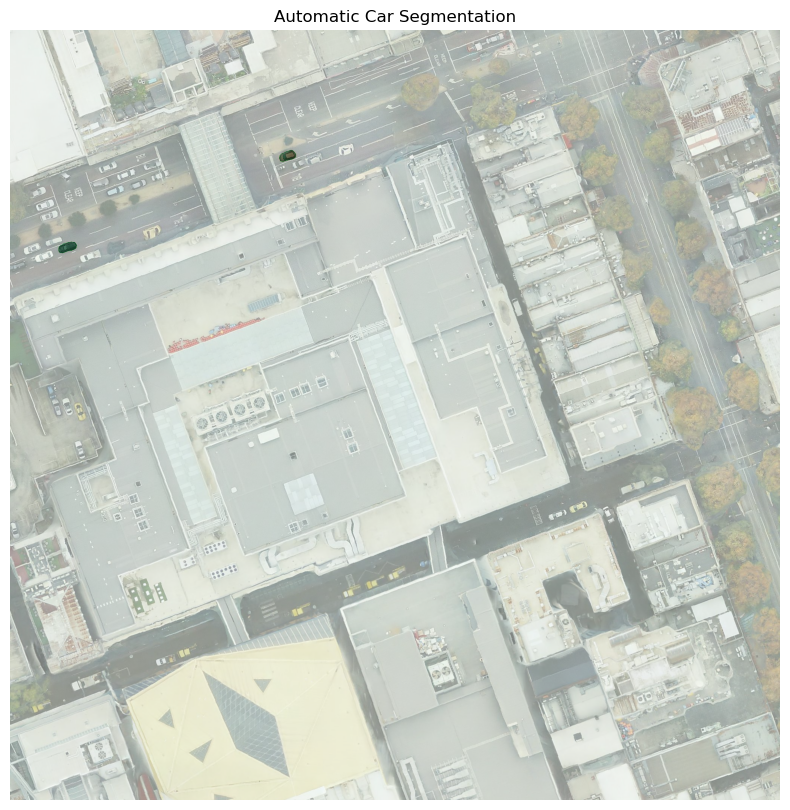

In [6]:
process_geotif_single_tile(IMAGE_PATH, CHECKPOINT_PATH, "auckland-0075m-urban-aerial-photos-2017")